# Mustererkennung in Funkmessdaten

## Aufgabe 1: Laden der Datenbank in Jupyter Notebook

In [1]:
# imports
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
hdf = pd.HDFStore('../../data/raw/TestMessungen_NEU.hdf')
print(hdf.keys)

<bound method HDFStore.keys of <class 'pandas.io.pytables.HDFStore'>
File path: ../../data/raw/TestMessungen_NEU.hdf
/x1/t1/trx_1_2            frame        (shape->[227,12009])
/x1/t1/trx_1_4            frame        (shape->[229,12009])
/x1/t1/trx_2_3            frame        (shape->[226,12009])
/x1/t1/trx_3_1            frame        (shape->[233,12009])
/x1/t1/trx_3_4            frame        (shape->[226,12009])
/x1/t1/trx_4_2            frame        (shape->[230,12009])
/x1/t2/trx_1_2            frame        (shape->[223,12009])
/x1/t2/trx_1_4            frame        (shape->[220,12009])
/x1/t2/trx_2_3            frame        (shape->[218,12009])
/x1/t2/trx_3_1            frame        (shape->[221,12009])
/x1/t2/trx_3_4            frame        (shape->[218,12009])
/x1/t2/trx_4_2            frame        (shape->[221,12009])
/x1/t3/trx_1_2            frame        (shape->[246,12009])
/x1/t3/trx_1_4            frame        (shape->[250,12009])
/x1/t3/trx_2_3            frame        (sha

## Aufgabe 2: Inspektion eines einzelnen Dataframes

In [3]:
# We examine x1_t1_trx_1_4 
df_x1_t1_trx_1_4 = hdf.get('/x1/t1/trx_1_4')
print("Shape of dataframe belonging to /x1/t1/trx_1_4:")
print(df_x1_t1_trx_1_4.shape)

Shape of dataframe belonging to /x1/t1/trx_1_4:
(229, 12009)


In [4]:
# get columns and filter columns belonging to certain sender receiver pairs
columns = list(df_x1_t1_trx_1_4)

print("Number of columns for sender receiver pairs:")
print()

r = re.compile('trx_1_4')
columns_1_4 = filter(r.match, columns)
print("Columns for pair 1 4:", len(list(columns_1_4)))

r = re.compile('trx_2_1')
columns_2_1 = filter(r.match, columns)
print("Columns for pair 2 1:", len(list(columns_2_1)))

r = re.compile('trx_2_4')
columns_2_4 = filter(r.match, columns)
print("Columns for pair 2 4:", len(list(columns_2_4)))

r = re.compile('trx_3_1')
columns_3_1 = filter(r.match, columns)
print("Columns for pair 3 1:", len(list(columns_3_1)))

r = re.compile('trx_3_4')
columns_3_4 = filter(r.match, columns)
print("Columns for pair 3 4:", len(list(columns_3_4)))

r = re.compile('trx_4_1')
columns_4_1 = filter(r.match, columns)
print("Columns for pair 4 1:", len(list(columns_4_1)))

print()
print("Other columns are:")
r = re.compile('(?!(trx_1_4|trx_2_1|trx_2_4|trx_3_1|trx_3_4|trx_4_1))')
columns_other = filter(r.match, columns)
for c in columns_other:
    print(c)
    
print()
print("So in sum we have 12009 columns.")

Number of columns for sender receiver pairs:

Columns for pair 1 4: 2001
Columns for pair 2 1: 2001
Columns for pair 2 4: 2001
Columns for pair 3 1: 2001
Columns for pair 3 4: 2001
Columns for pair 4 1: 2001

Other columns are:
index
Timestamp
target

So in sum we have 12009 columns.


In [5]:
# We examine x3_t2_trx_3_1 
df_x3_t2_trx_3_1 = hdf.get('/x3/t2/trx_3_1')
print("Shape of dataframe belonging to /x3/t2/trx_3_1:")
print(df_x3_t2_trx_3_1.shape)

Shape of dataframe belonging to /x3/t2/trx_3_1:
(247, 12009)


In [6]:
# get columns and filter columns belonging to certain sender receiver pairs
columns = list(df_x3_t2_trx_3_1)

print("Number of columns for sender receiver pairs:")
print()

r = re.compile('trx_1_3')
columns_1_3 = filter(r.match, columns)
print("Columns for pair 1 3:", len(list(columns_1_3)))

r = re.compile('trx_2_1')
columns_2_1 = filter(r.match, columns)
print("Columns for pair 2 1:", len(list(columns_2_1)))

r = re.compile('trx_2_3')
columns_2_3 = filter(r.match, columns)
print("Columns for pair 2 3:", len(list(columns_2_3)))

r = re.compile('trx_3_1')
columns_3_1 = filter(r.match, columns)
print("Columns for pair 3 1:", len(list(columns_3_1)))

r = re.compile('trx_4_1')
columns_4_1 = filter(r.match, columns)
print("Columns for pair 4 1:", len(list(columns_4_1)))

r = re.compile('trx_4_3')
columns_4_3 = filter(r.match, columns)
print("Columns for pair 4 3:", len(list(columns_4_3)))


print()
print("Other columns are:")
r = re.compile('(?!(trx_1_3|trx_2_1|trx_2_3|trx_3_1|trx_4_3|trx_4_1))')
columns_other = filter(r.match, columns)
for c in columns_other:
    print(c)
    
print()
print("So in sum we have 12009 columns.")

Number of columns for sender receiver pairs:

Columns for pair 1 3: 2001
Columns for pair 2 1: 2001
Columns for pair 2 3: 2001
Columns for pair 3 1: 2001
Columns for pair 4 1: 2001
Columns for pair 4 3: 2001

Other columns are:
index
Timestamp
target

So in sum we have 12009 columns.


### We can see that in each connection log between two devices, the involved devices measure the signals between each other. The not directly involved devices listen and record the signals from both of the sending devices.

In [7]:
# Next we take a look at the target columns

target_set = set(df_x1_t1_trx_1_4["target"])
print('The unique values of the target column in /x1/t1/trx_1_4 are:')
print()
for v in target_set:
    print(v)

print()

target_set = set(df_x3_t2_trx_3_1["target"])
print('The unique values of the target column in /x3/t2/trx_3_1 are:')
print()
for v in target_set:
    print(v)

The unique values of the target column in /x1/t1/trx_1_4 are:

Standing_1.0,1.0_1.0,1.0
Empty_0.0,0.0_0.0,0.0
Standing_1.0,2.0_1.0,2.0
Step_2.0,1.0_1.0,1.0
Walking_0.0,0.0_0.0,0.0
Step_1.0,1.0_1.0,2.0
Step_1.0,2.0_2.0,2.0
Standing_2.0,1.0_2.0,1.0
Standing_2.0,2.0_2.0,2.0
Step_2.0,2.0_2.0,1.0

The unique values of the target column in /x3/t2/trx_3_1 are:

Standing_1.0,1.0_1.0,1.0
Empty_0.0,0.0_0.0,0.0
Standing_1.0,2.0_1.0,2.0
Step_2.0,1.0_1.0,1.0
Walking_0.0,0.0_0.0,0.0
Step_1.0,1.0_1.0,2.0
Step_1.0,2.0_2.0,2.0
Standing_2.0,1.0_2.0,1.0
Standing_2.0,2.0_2.0,2.0
Step_2.0,2.0_2.0,1.0


## Aufgabe 3: Visualisierung der Messreihe des Datensatz

In [8]:
# get necessary data
vals = df_x1_t1_trx_1_4.loc[:,'trx_2_4_ifft_0':'trx_2_4_ifft_1999'].values

/gpfs/software/x86_64/anaconda/envs/anaconda431-py35-with-jupyter_cms/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


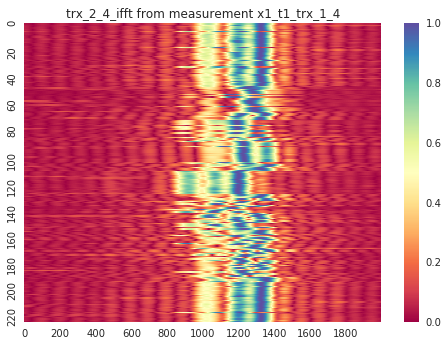

In [9]:
# Spectral scheme
fig, ax = plt.subplots()
plt.title('trx_2_4_ifft from measurement x1_t1_trx_1_4')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Spectral')
plt.show()

/gpfs/software/x86_64/anaconda/envs/anaconda431-py35-with-jupyter_cms/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


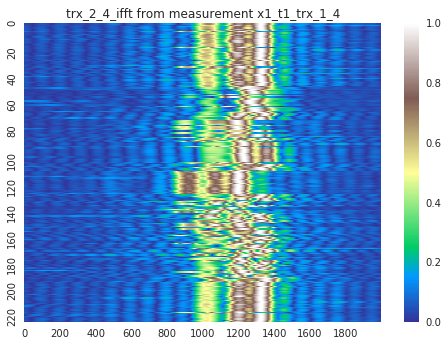

In [10]:
# terrain scheme
fig, ax = plt.subplots()
plt.title('trx_2_4_ifft from measurement x1_t1_trx_1_4')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='terrain')
plt.show()

/gpfs/software/x86_64/anaconda/envs/anaconda431-py35-with-jupyter_cms/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


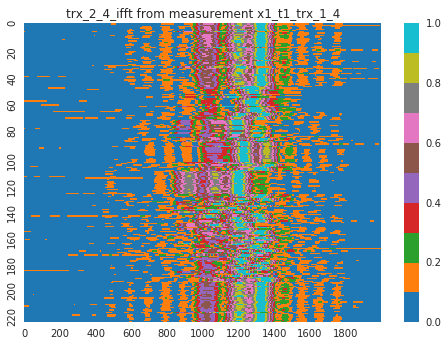

In [11]:
# Vega10 scheme
fig, ax = plt.subplots()
plt.title('trx_2_4_ifft from measurement x1_t1_trx_1_4')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Vega10')
plt.show()

/gpfs/software/x86_64/anaconda/envs/anaconda431-py35-with-jupyter_cms/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


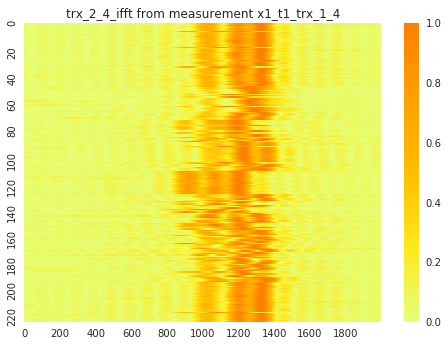

In [12]:
# Wistia scheme
fig, ax = plt.subplots()
plt.title('trx_2_4_ifft from measurement x1_t1_trx_1_4')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Wistia')
plt.show()

## Aufgabe 4: Groundtruth-Label anpassen

In [13]:
df_x1_t1_trx_3_1 = hdf.get('/x1/t1/trx_3_1')

print("Target values before transformation:")
print("10 is",df_x1_t1_trx_3_1['target'][10])
print("82 is",df_x1_t1_trx_3_1['target'][82])
print("151 is",df_x1_t1_trx_3_1['target'][151])
print()

# transform_labels(df_x1_t1_trx_3_1)
# set Empty
df_x1_t1_trx_3_1["target"] = df_x1_t1_trx_3_1["target"].replace("Empty.*", "Empty", regex=True)
# set Not Empty
df_x1_t1_trx_3_1["target"] = df_x1_t1_trx_3_1["target"].replace("^(?!.*Empty).*$", "Not Empty", regex=True)

print("Target values after transformation:")
print("10 is",df_x1_t1_trx_3_1['target'][10])
print("82 is",df_x1_t1_trx_3_1['target'][82])
print("151 is",df_x1_t1_trx_3_1['target'][151])

Target values before transformation:
10 is Empty_0.0,0.0_0.0,0.0
82 is Standing_1.0,2.0_1.0,2.0
151 is Walking_0.0,0.0_0.0,0.0

Target values after transformation:
10 is Empty
82 is Not Empty
151 is Not Empty
